In [ ]:
import pandas
import numpy as np
import keras
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pandas.read_csv('/content/drive/MyDrive/threeminutes.csv')

In [ ]:
dataset.head()

,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,sma_3,ema_3,atr,adx,cci,rsi,wr,roc,stochrsi_d,stochrsi_k,fi_3
0,AFKS,-0.003,0.001,0.001,-0.010,56600,20.093333,20.089749,0.016618,47.669710,-100.000000,40.693429,-87.500000,-0.059722,0.666667,0.333333,-231.890327
1,AFKS,-0.011,-0.002,0.000,-0.001,32200,20.088333,20.084874,0.015412,48.743718,-73.684211,38.390047,-93.750000,-0.069673,0.333333,0.000000,-132.045163
2,AFKS,0.013,0.002,0.001,0.015,114500,20.088000,20.088937,0.015275,54.164376,100.000000,72.901718,-0.000000,0.019909,0.222222,0.333333,792.727418
3,AFKS,-0.003,0.000,-0.005,-0.007,58000,20.087667,20.089469,0.016516,42.971297,-20.000000,52.367608,-36.842105,0.034859,0.267223,0.468337,193.363709
4,AFKS,-0.002,-0.005,-0.036,-0.031,137500,20.090333,20.088734,0.027678,57.971299,-100.000000,18.239671,-69.090909,-0.114542,0.423335,0.468337,-2034.568145


In [ ]:
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.interpolate(inplace = True)

In [ ]:
data = dataset[['TICKER', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL', 'sma_3', 'ema_3', 'atr', 'adx', 'cci', 'rsi', 'wr']]

In [ ]:
horizon = 1

In [ ]:
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.losses import CategoricalCrossentropy
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

class Model:
    def __init__(self, n_steps, data):
        print('Init...')
        self.n_steps = n_steps
        self.data = data

    def scale_data(self, data):
        print('Scaling data...')
        scaler = StandardScaler()
        self.data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL', 'sma_3', 'ema_3', 'atr', 'adx', 'cci', 'rsi', 'wr']] = scaler.fit_transform(
            self.data[['OPEN', 'HIGH', 'LOW', 'CLOSE', 'VOL', 'sma_3', 'ema_3', 'atr', 'adx', 'cci', 'rsi', 'wr']])


    def split_sequence(self, what_to_predict, prediction_horizon):
        print('Spliting sequences...')
        self.prediction_horizon = prediction_horizon
        X, y = list(), list()
        for element in data['TICKER'].unique():
            sequences = data[data['TICKER'] == element].drop(columns = 'TICKER').to_numpy()
            for i in range(len(sequences)):
                # find the end of this pattern
                end_ix = i + self.n_steps
                # check if we are beyond the sequence
                if end_ix > len(sequences)-1-self.prediction_horizon:
                    break
                # gather input and output parts of the pattern
                if what_to_predict == 'Open':
                    seq_x, seq_y = sequences[i:end_ix], sequences[end_ix: end_ix + self.prediction_horizon, 0]
                if what_to_predict == 'High':
                    seq_x, seq_y = sequences[i:end_ix], sequences[end_ix: end_ix + self.prediction_horizon, 1]
                if what_to_predict == 'Low':
                    seq_x, seq_y = sequences[i:end_ix], sequences[end_ix: end_ix + self.prediction_horizon, 2]
                if what_to_predict == 'Close':
                    seq_x, seq_y = sequences[i:end_ix], sequences[end_ix: end_ix + self.prediction_horizon, 3]
                if what_to_predict == 'Class':
                    seq_y = []
                    for j in range(self.prediction_horizon):
                        seq_y_j = [sequences[end_ix + j][0] > 0, 
                                   sequences[end_ix + j][0] < 0]
                                   #sequences[end_ix + j][0] == 0]
                        seq_y.append(np.array(seq_y_j).astype(int))
                    seq_x = sequences[i:end_ix]
                X.append(seq_x)
                y.append(seq_y)
        self.X, self.Y = np.array(X), np.array(y)


    def create_train_test(self):
        print('Creating train set...')
        print(self.X.shape, self.Y.shape)
        return self.X, self.Y

In [ ]:
model = Model(10, data)
model.scale_data(data)
model.split_sequence('Close', horizon)
X, Y = model.create_train_test()

Init...
Scaling data...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Spliting sequences...
Creating train set...
(1654979, 10, 12) (1654979, 1)


In [ ]:
import gc
del data 
gc.collect()

3077

In [ ]:
print(X.shape)

(1654979, 10, 12)


In [ ]:
## Dataloader
from torch import tensor
from torch.utils.data import Dataset, DataLoader
class StockPriceDataset(Dataset):

    def __init__(self, X, Y, batch_size):
        self.X = tensor(X)
        self.Y = tensor(Y)
        self.batch_size = batch_size

    def __len__(self):
        return (len(self.X) // self.batch_size) * self.batch_size

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()


        sample = (X[idx], Y[idx])

        return sample

In [ ]:
import torch
import torch.nn as nn
def loss_criterion(Y_pred, Y_true):
    mse_loss = nn.MSELoss()
    eps=1e-7
    return mse_loss(Y_pred, Y_true)+eps

In [ ]:
def accuracy_criterion(Y_pred, Y_true):
    Y_pred_converted = torch.argmax(Y_pred, dim = 2)
    Y_true_converted = torch.argmax(Y_true, dim = 2)
    return torch.eq(Y_pred_converted, Y_true_converted).float().mean()

In [ ]:
#model
from torch import nn
class LSTMStock(nn.Module):

    def __init__(self, n_steps, input_size, hidden_dim, prediction_horizon, classes, batch_size):
        super(LSTMStock, self).__init__()

        self.prediction_horizon = prediction_horizon
        self.classes = classes
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.lstm = nn.LSTM(input_size, self.hidden_dim, num_layers = 2, dropout = 0.2)
        self.hidden = nn.Linear(self.hidden_dim * self.n_steps, self.prediction_horizon * self.classes)
        self.softmax = nn.Softmax(dim = 2)

    def forward(self, X):
        lstm_out, _ = self.lstm(X)
        hidden_out = self.hidden(torch.flatten(lstm_out.squeeze().permute(1, 0, 2), start_dim= 1))
        hidden_out_reshaped = hidden_out.reshape(self.batch_size, self.prediction_horizon, self.classes)
        softmaxed = self.softmax(hidden_out_reshaped)
        return softmaxed

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [ ]:
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
train_batch_size = 16
test_batch_size = 16
train_dataset = StockPriceDataset(X_train, Y_train, train_batch_size)
test_dataset = StockPriceDataset(X_test, Y_test, test_batch_size)
print(dataset.__len__())
train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_batch_size)
model = LSTMStock(10, 12, 64, horizon, 2, train_batch_size)
optimizer = torch.optim.Adam(model.parameters()) ### МОЖНО НАСТРАИВАТЬ ###
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
epochs = 1
train_loss_cumul = 0
val_loss_cumul = 0
train_accuracy_cumul = 0
val_accuracy_cumul = 0
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []
train_size = 0
val_size = 0
for epoch in range(epochs):
    print('Epoch:', epoch + 1)
    #train
    model.train()
    print("Training")
    for x, y in tqdm_notebook(train_dataloader):
        # find loss
        x = x.permute(1, 0, 2).float().to(DEVICE)
        y = y.to(DEVICE)
        model = model.to(DEVICE)
        output = model(x.float()).float()
        loss = loss_criterion(output.float(), y.float()).mean().float()

        #step
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        # accumulate loss and loss history
        # print loss
        train_size += 1
        train_loss_cumul += loss.detach().item()
        train_loss_history.append(train_loss_cumul / train_size)
        if train_size % 1000 == 0:
            print(train_loss_cumul / train_size)

1655199
Epoch: 1
Training


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/77577 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1.1883199789971113
1.274279890589416
1.2158374554514886
1.1794538881070913
1.1739447990655898
1.1702074219708642
1.1648406457794565
1.1671657419335097
1.1636230295168029
1.166627225625515
1.172496383745562
1.1739917132357756
1.1666081726642756
1.1622649724589926
1.1545578734437625
1.1558961816793307
1.153312206448001
1.1555679918660058
1.1483900036788302
1.1473797373279928
1.1499159183722167
1.1464278832254085
1.141882608965687
1.1433531996744375
1.1593041993206739
1.161741845944753
1.1572551483892732
1.159565254624933
1.1583323905036367
1.1567598237713177
1.156480605878657
1.1554826666074804
1.1566747164766897
1.1560752683286282
1.1555392645090818
1.1506753740294111
1.1540175992282662
1.1526773469840226
1.1564337454980764
1.1549931769695132
1.1655005949484867
1.164531060138274
1.1697328339142854
1.1705352590490472
1.1706474575152
1.168407421094244
1.1675921906841562
1.1668952669044956
1.1694594880135691
1.1678141389000416
1.1683764212493803
1.1697100649089194
1.1682036933910172
1.1718

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 
def return_predictions_light(model, dataloader):
    model.eval()
    mse = 0
    mae = 0
    for x_test, y_test in tqdm_notebook(dataloader):
        y_test = y_test.squeeze().to(DEVICE)
        x_test = x_test.squeeze().permute(1, 0, 2).float().to(DEVICE)
        model = model.to(DEVICE)
        output = torch.argmax(model(x_test), 2).squeeze()
        y_test = torch.argmax(y_test, 2).squeeze()
        output = output.squeeze().detach().cpu().numpy().astype(float)
        y_test = y_test.squeeze().detach().cpu().numpy().astype(float)
        output = output.reshape(output.shape[0] * output.shape[1])
        y_test = y_test.reshape(y_test.shape[0] * y_test.shape[1])
        mse += mean_squared_error(y_test, output)
        mae += mean_absolute_error(y_test, output)
    return mse / len(dataloader), mae / len(dataloader)

In [ ]:
mse, mae = return_predictions_light(model, test_dataloader)
print('MSE:', mse)
print('MAE:', mae)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/25859 [00:00<?, ?it/s]

IndexError: ignored

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix
def return_predictions_light(model, dataloader):
    model.eval()
    cm = np.zeros((2, 2))
    accuracy = 0
    f1 = 0
    precision = 0
    recall = 0
    roc_auc = 0
    for x_test, y_test in tqdm_notebook(dataloader):
        y_test = y_test.squeeze().to(DEVICE)
        x_test = x_test.squeeze().permute(1, 0, 2).float().to(DEVICE)
        model = model.to(DEVICE)
        output = torch.argmax(model(x_test), 2).squeeze()
        y_test = torch.argmax(y_test, 2).squeeze()
        output = output.squeeze().detach().cpu().numpy().astype(int)
        y_test = y_test.squeeze().detach().cpu().numpy().astype(int)
        output = output.reshape(output.shape[0] * output.shape[1])
        y_test = y_test.reshape(y_test.shape[0] * y_test.shape[1])
        accuracy += accuracy_score(y_test, output)
        f1 += f1_score(y_test, output)
        precision += precision_score(y_test, output)
        recall += recall_score(y_test, output)
        #roc_auc += roc_auc_score(y_test, output)
        cm += confusion_matrix(y_test, output)
    return accuracy / len(dataloader), f1 / len(dataloader), precision / len(dataloader), recall / len(dataloader), cm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



accuracy: 0.6665409850857854
f1: 0.7697770776336493
precision: 0.6527155080497614
recall: 0.9586095234129819


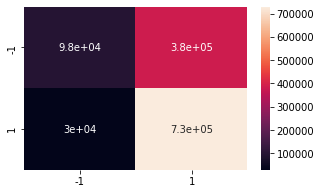

In [ ]:
import seaborn
#predictions, y_test_array = return_predictions(model, test_dataloader)
accuracy, f1, precision, recall, cm = return_predictions_light(model, test_dataloader)
print('accuracy:', accuracy)
print('f1:', f1)
print('precision:', precision)
print('recall:', recall)
#print('auc:', auc(predictions, y_test_array))
#print('roc-auc:', roc_auc)
df_cm = pandas.DataFrame(cm, index = [i for i in [-1, 1]],
                  columns = [i for i in [-1, 1]])
plt.figure(figsize = (5,3))
seaborn.heatmap(df_cm, annot=True)